# Trabalho 5
Aluno: Diego Freitas Holanda

Matricula: 411627

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, norm, multivariate_normal
import ipywidgets as widgets
%matplotlib inline

## PPCA

In [2]:
mnist = np.genfromtxt('./mnist_5.csv', delimiter=',')

In [3]:
def normal(x: np.ndarray, mi: np.ndarray, cov: np.ndarray) -> np.ndarray:
    N = len(x)

    temp1 = np.linalg.det(cov) ** (-1/2)
    temp2 = np.exp(-0.5 * (x - mi).T @ np.linalg.inv(cov) @ (x - mi))

    return (2 * np.pi) ** (-N/2) * temp1 * temp2

### Implementação do modelo

In [4]:
class PPCA:
    
    def __init__(self, L: int):
        self.L = L
    
    def fit(self, X: np.ndarray):
        D = X.shape[1]
        
        assert D >= self.L
        
        self.mean = np.mean(X, axis=0)
        self.S = np.cov(X, rowvar=False) + 1e-12 * np.identity(X.shape[1])
        w, v = np.linalg.eig(self.S)
        self.V = v[:self.L].T
        self.lamb = np.diag(w[:self.L])
        self.std = np.mean(w[self.L:]) if self.L < D else 1e-12
        self.W = self.V@((self.lamb - (self.std * np.eye(self.L)))**(1/2))
        self.M = self.W.T @ self.W + (self.std * np.eye(self.L))
        
        self.inv_m = np.linalg.inv(self.M)
        self.g_mean = self.inv_m @ self.W.T
        self.g_std = self.std * self.inv_m
    
    def transform(self, X: np.ndarray) -> np.ndarray:
        std = np.absolute(self.g_std)
        return np.absolute(self.g_mean @ (X - self.mean).T).T, std
    
    def project(self, x: np.ndarray) -> np.ndarray:
        return np.absolute(self.g_mean @ (x - self.mean)), np.absolute(self.g_std)
    
    def restore(self, z: np.ndarray) -> np.ndarray:
        return np.absolute(self.W @ z + self.mean), np.absolute(self.std * np.eye(len(self.W)))

In [5]:
model = PPCA(2)

In [6]:
model.fit(mnist)

In [7]:
means, std = model.transform(mnist[:500])

In [8]:
def get_discrete_space(xmin, xmax, ymin, ymax, resolution):
    x1 = np.linspace(xmin, xmax, resolution)
    x2 = np.linspace(ymin, ymax, resolution)
    x1, x2 = np.meshgrid(x1, x2)
    grid = np.vstack([x1.reshape(-1), x2.reshape(-1)]).T
    return grid

def plot_normals(grid, dist):
    normals = np.array([[d.pdf(x) for d in dist] for x in grid])
    grid_n = np.sum(normals / (normals.max(axis=0) + 1e-12), axis=1)
    
    side = int(len(grid_n)**(1/2))
    plt.imshow(
        grid_n.reshape(side, side),
        extent=[-1, 1, 1, -1],
        vmin=grid_n.min(),
        vmax=grid_n.max(),
        interpolation='bilinear'
    )

In [9]:
def compare_images(model, x):
    
    mean, std = model.project(x)
    zdist = multivariate_normal(mean=mean, cov=std)
    
    rest_mean, rest_std = model.restore(mean@std)
    restdist = multivariate_normal(mean=rest_mean, cov=rest_std)
    
    rest_img = restdist.rvs(size=10)
    
    fig, ax = plt.subplots(ncols=2, tight_layout=True)
    ax[0].imshow(x.reshape(28,28),cmap='Greys')
    ax[1].imshow((rest_mean@rest_std).reshape(28,28),cmap='Greys')

### Reconstrução

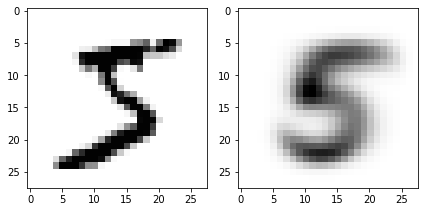

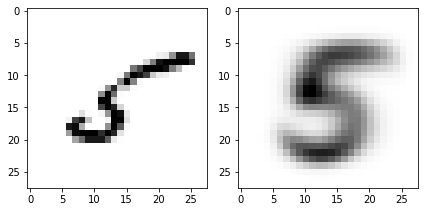

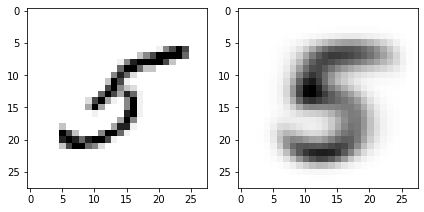

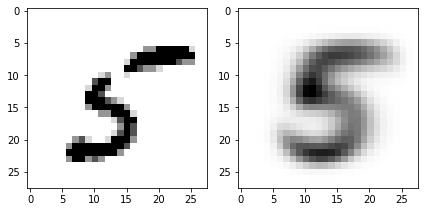

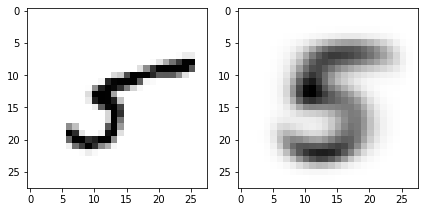

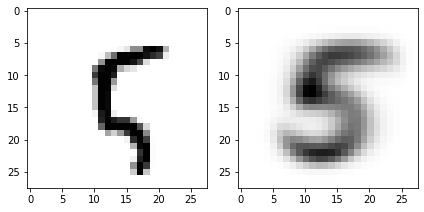

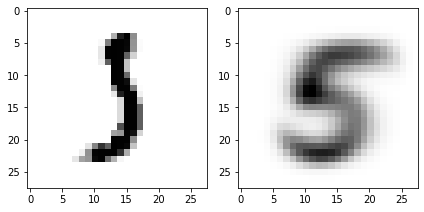

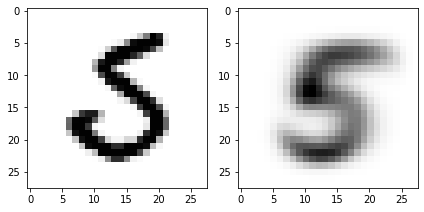

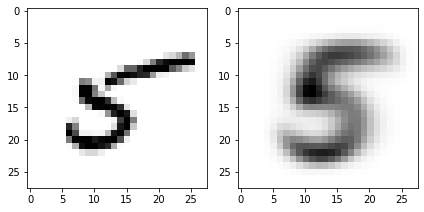

In [10]:
for i in range(9):
    compare_images(model, mnist[i])

## Inferencia Variacional

In [11]:
gaussian1d = np.genfromtxt('./gaussian_1d.csv', delimiter=',')

### Implementação do modelo

In [12]:
class Gaussian1D:
    
    def __init__(self, mi, k, a, b):
        self.mi0 = mi
        self.k0 = k
        self.a0 = a
        self.b0 = b
    
    def fit(self, X: np.ndarray):
        N = len(X)
        
        self.evidence = []
        self.mi_n = (self.k0 * self.mi0 + np.sum(X)) / (self.k0 +  N)
        self.a_n = self.a0 + (N + 1) / 2
        
        self.k_n = self.k0
        self.b_n = self.b0
        
        self.evidence.append(self._evidence(X, self.mi_n, self.k_n, self.a_n, self.b_n))
        
        for i in range(20):
            self.k_n = (self.k0 + N)*(self.a_n / self.b_n)
            self.b_n = self.b0 + (self.k0/2) * ((1/self.k_n) + (self.mi_n - self.mi0)**2) + 0.5 * np.sum((1/self.k_n) + (X - self.mi_n)**2)
            
            self.evidence.append(self._evidence(X, self.mi_n, self.k_n, self.a_n, self.b_n))
            
    
    def _evidence(self, X: np.ndarray, mi, k, a, b) -> float:
        
        tao_dist = gamma(a, scale=1/b)
        tao = tao_dist.expect()
        
        mi_dist = norm(loc=mi, scale=1/k)

        normal_dist = norm(loc=mi_dist.expect(), scale=1/tao)
        prod = 1
        for x in X:
            prod *= normal_dist.pdf(x)
        
        return prod

In [13]:
def plot_distributions(model, title=''):
    fig, ax = plt.subplots(figsize=(15,5), ncols=2)
    
    # Mi
    fig.suptitle(title, fontsize=16)
    post_mi_dist = norm(loc=model.mi_n, scale=1/model.k_n)
    rangex = prior_mi_dist.std()
    x = np.linspace(-3*rangex, 3*rangex, 1000)

    ax[0].plot(x, post_mi_dist.pdf(x), label='Posterior');
    ax[0].plot(x, prior_mi_dist.pdf(x), label='Prior');
    ax[0].axvline(x=model.mi_n, color='red', label=f'$mi={model.mi_n:.2f}$');
    ax[0].legend();
    ax[0].set_title('Mi Distribuitions')

    # Tao
    post_tal_dist = gamma(model.a_n, scale=1/model.b_n)
    rangex = post_tal_dist.std()
    x = np.linspace(0, 20, 1000)

    ax[1].plot(x, post_tal_dist.pdf(x), label='Posterior');
    ax[1].plot(x, prior_tal_dist.pdf(x), label='Prior');
    ax[1].axvline(x=post_tal_dist.expect(), color='red', label=f'$tao={post_tal_dist.expect():.2f}$')
    ax[1].legend();
    ax[1].set_title('Tao Distribuitions')

### Experimentos

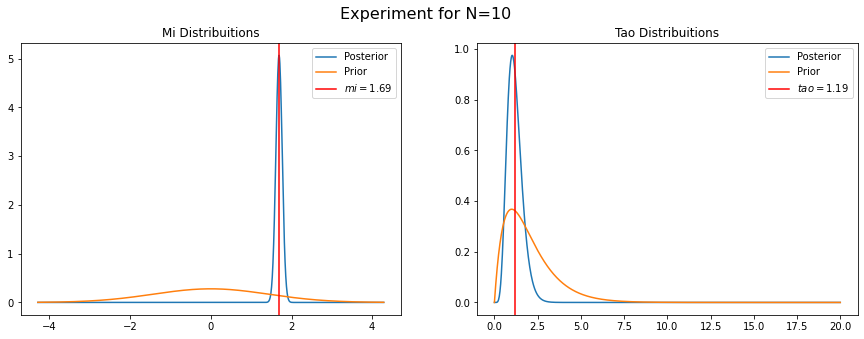

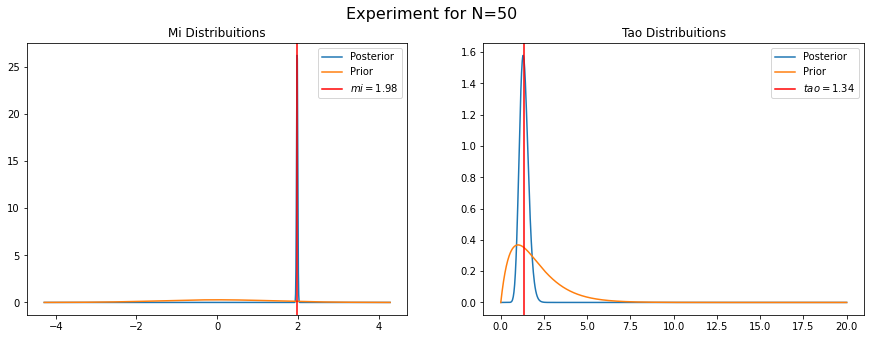

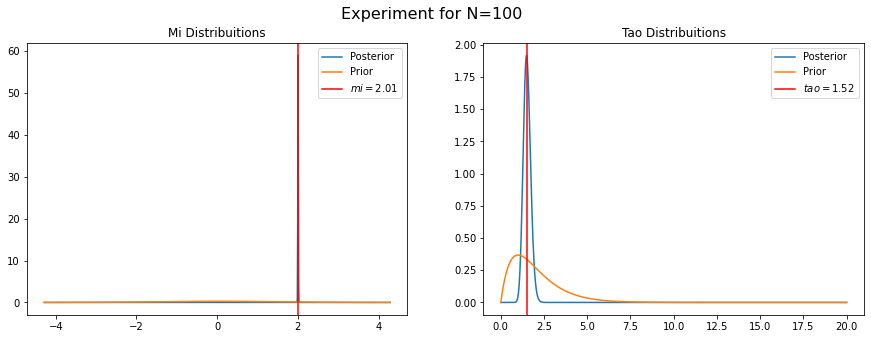

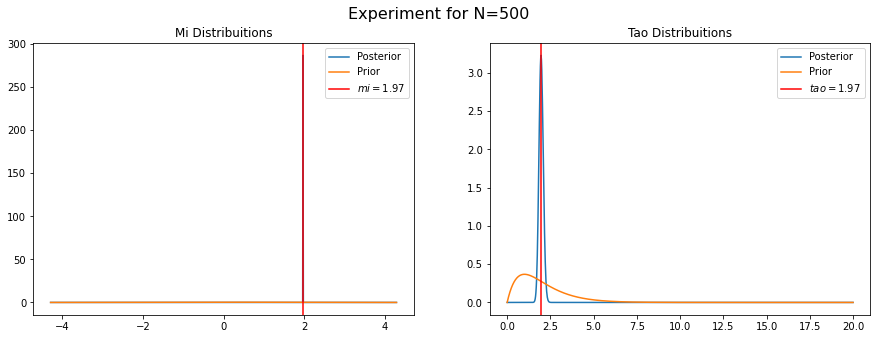

In [14]:
experiments = [10, 50, 100, 500]

prior_mi = 0
prior_k = 0.70
prior_mi_dist = norm(loc=prior_mi, scale=1/prior_k)

a0 = 2
b0 = 1
prior_tal_dist = gamma(a0, scale=1/b0)

for N in experiments:    
    model = Gaussian1D(prior_mi, prior_k, a0, b0)

    model.fit(gaussian1d[:N])
    
    plot_distributions(model, f'Experiment for N={N}')